In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, preps, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(preps)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

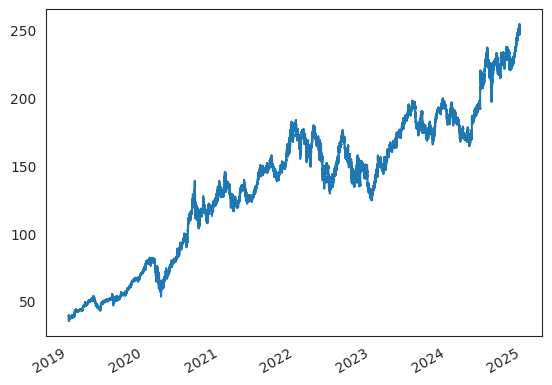

,atr_pct_7,range_pct,atr_pct_28,ret_std_63,donch_w_20,ret_std_21,atr_pct_14,time_afthour,kc_w_20_20_1.5,bb_w_20_2p0,dist_low_200,time_in_sess,donch_w_55,trade_count,bb_w_50_2p0,lower_shad,time_premark,upper_shad,dist_high_200,time_hour,volume,time_minute,time_week_of_year,sma_pct_200,atr_7_RZ,time_month,atr_14_RZ,time_day_of_year,adx_28,vol_spike_28,sma_pct_50,atr_28_RZ,roc_5,body_pct,plus_di_14,roll_vwap_20_RZ,minus_di_7,plus_di_28,plus_di_7,rolling_max_close_200_RZ,minus_di_28,sma_pct_100,minus_di_14,roc_21,ret,rolling_min_close_200_RZ,rsi_21,ema_8_RZ,vol_spike_14,macd_signal_6_13_5_RZ,close_raw,targ_signal,signal_thresh,atr_14_raw,adx_14_raw,rsi_6_raw,vwap_ohlc_close_session_raw,pred_signal,ask,bid
2019-01-02 08:14:00,0.334698,0.000000,0.392997,1.000000,1.000000,1.000000,0.447489,0.0,0.431615,1.000000,0.257033,0.0,1.000000,0.000170,1.000000,0.000000,1.0,0.0,0.776497,0.270833,0.001087,0.280556,0.500000,0.000000,0.565423,0.500000,1.000000,0.502740,0.583460,0.095754,0.000000,1.000000,0.692459,0.502374,0.203032,0.000000,0.662782,0.159196,0.304990,0.624997,1.000000,0.000000,0.937431,0.000000,0.611895,0.366899,0.070631,0.000000,0.130988,0.000000,38.5675,0.244624,0.121416,0.047057,59.010090,41.082134,38.501368,0.077390,38.575213,38.559787
2019-01-02 08:15:00,0.305852,0.000000,0.383940,1.000000,1.000000,1.000000,0.425311,0.0,0.417247,1.000000,0.269168,0.0,1.000000,0.000255,1.000000,0.000000,1.0,0.0,0.764285,0.270833,0.001568,0.281250,0.500000,0.000000,0.519175,0.500000,1.000000,0.502740,0.596606,0.133983,0.000000,1.000000,0.711105,0.502374,0.226999,0.000000,0.620956,0.177827,0.350781,0.624997,1.000000,0.000000,0.914491,0.000000,0.611852,0.366899,0.093563,0.000000,0.170633,0.000000,38.5825,0.143672,0.121416,0.044767,58.753659,47.074586,38.504969,0.072108,38.590216,38.574784
2019-01-02 08:16:00,0.297513,0.206802,0.379997,1.000000,1.000000,1.000000,0.413568,0.0,0.409749,1.000000,0.261079,0.0,1.000000,0.003570,1.000000,0.000000,1.0,0.1,0.772426,0.270833,0.009353,0.281944,0.500000,0.000000,0.505618,0.500000,0.980671,0.502740,0.607506,0.641640,0.000000,1.000000,0.646682,0.389001,0.250862,0.000000,0.547091,0.196904,0.387007,0.624997,1.000000,0.000000,0.872280,0.000000,0.426359,0.366899,0.089474,0.000000,0.699579,0.000000,38.5725,0.192660,0.121416,0.043534,58.168356,43.532485,38.517860,0.086245,38.580214,38.564785
2019-01-02 08:17:00,0.319644,0.376223,0.384498,1.000000,1.000000,1.000000,0.418254,0.0,0.413727,1.000000,0.242863,0.0,1.000000,0.001275,1.000000,0.000000,1.0,0.0,0.790758,0.270833,0.002932,0.282639,0.500000,0.000000,0.540951,0.500000,0.991183,0.502740,0.618596,0.205787,0.000000,1.000000,0.540769,0.124586,0.228136,0.000000,0.532115,0.183259,0.308734,0.624997,1.000000,0.000000,0.846978,0.000000,0.333591,0.366899,0.080282,0.000000,0.215910,0.000000,38.5500,0.285360,0.121416,0.043996,57.771435,36.181791,38.519767,0.098775,38.557710,38.542290
2019-01-02 08:18:00,0.343754,0.313417,0.390004,1.000000,1.000000,1.000000,0.425102,0.0,0.419544,1.000000,0.252986,0.0,1.000000,0.001360,1.000000,0.000000,1.0,0.0,0.780571,0.270833,0.002959,0.283333,0.500000,0.000000,0.579932,0.500000,1.000000,0.502740,0.628853,0.200238,0.000000,1.000000,0.532452,0.187584,0.214090,0.000000,0.424040,0.175435,0.261863,0.624997,1.000000,0.000000,0.771884,0.000000,0.593342,0.366899,0.100739,0.000000,0.210063,0.000000,38.5625,0.307641,0.121416,0.044722,57.313376,42.638940,38.522179,0.107312,38.570212,38.554788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-18 23:55:00,0.072681,0.000000,0.119045,0.173271,0.039900,0.151082,0.087718,1.0,0.101193,0.042412,0.073901,0.0,0.072731,0.008414,0.074667,0.000000,0.0,0.0,0.131484,0.895833,0.003841,0.934028,0.461538,0.512824,0.109456,0.416667,0.125414,0.464384,0.000000,0.759793,0.536291,0.141305,0.509615,0.502374,0.417085,0.560666,0

In [3]:
###### ML STRATEGIES DF ######

df_trainval = pd.read_csv(params.pred_trainval_csv, index_col=0, parse_dates=True)

df_trainval.close_raw.plot() ; plt.show()
df_trainval

In [4]:
# # ##### 5 ######
# {'reset_peak': (1, 1),
#  'rsi_min_thresh': (21, 29),
#  'rsi_max_thresh': (60, 74),
#  'adx_thresh': (8.018379455902043, 16.03396054409796),
#  'atr_mult': (24.726563105324534, 30.726826894675465),
#  'vwap_atr_mult': (1.1320614885122513, 9.46073851148775),
#  'buy_factor': (0.31505719971993146, 0.6012728002800687),
#  'sell_factor': (-0.002279885026673041, 0.03658988502667304),
#  'trailstop_pct': (30.294243131720588, 36.21820686827942),
#  'thresh_choice': {'categorical': ['roll_p90']},
#  'thresh_window': (9.428644689126353, 20.57135531087365)}


In [5]:
col_signal = "pred_signal"

prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50

def objective(trial: optuna.Trial) -> float:
    reset_peak       = trial.suggest_categorical("reset_peak", [True, False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 20, 30)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 55), 80)
    adx_thresh       = trial.suggest_float("adx_thresh", 8.0, 16.0)
    atr_mult         = trial.suggest_float("atr_mult", 23, 32, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", 1, 10)
    buy_factor       = trial.suggest_float("buy_factor", 0.3, 0.6)
    sell_factor      = trial.suggest_float("sell_factor", 0.001, 0.1)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 20.0, 40.0)

    thresh_mode = trial.suggest_categorical("thresh_mode", ["roll_p90","numeric"])
    
    if thresh_mode == "numeric":
        thresh_mode_num = trial.suggest_float("thresh_mode_num", 0.01, 1.0) 
        thresh_window = None
    else:
        thresh_mode_num = None
        thresh_window = trial.suggest_int("thresh_window", 5, 30) if thresh_mode.startswith("roll") else None

    print('-' * 160)
    print("TRIAL", trial.number, "Params =>", "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))
    
    df_thresh = preps.apply_thresholds_per_day(
        df = df_trainval.copy(),
        col_signal = col_signal,  
        thresh_mode = thresh_mode,
        thresh_window = thresh_window,
        thresh_mode_num = thresh_mode_num
    )

    start_ask = df_thresh.loc[df_thresh.index.normalize() == df_thresh.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation

    groups = df_thresh.groupby(df_thresh.index.normalize())
    
    pbar = tqdm(groups, desc=f"Gen&Sim", leave=True)

    acc = opts.TrialAccumulator(trial, pbar, report_interval=report_interval, prun_perc=prun_perc)
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = col_signal,
            sign_thresh     = "signal_thresh",
            col_atr         = 'atr_14_raw',
            col_adx         = 'adx_14_raw',
            col_rsi         = 'rsi_6_raw',
            col_vwap        = 'vwap_ohlc_close_session_raw',
            col_close       = 'close_raw',
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        # process results and possibly prune
        acc.process(sim_results, step, parse_eq_value_callable=strats._parse_eq_value)

        # cleanup
        del df_actions, sim_results
        df_day = df_actions = sim_results = None

    # finalize and return objective
    return acc.finalize()


Baseline mean daily B&H: 359.9210


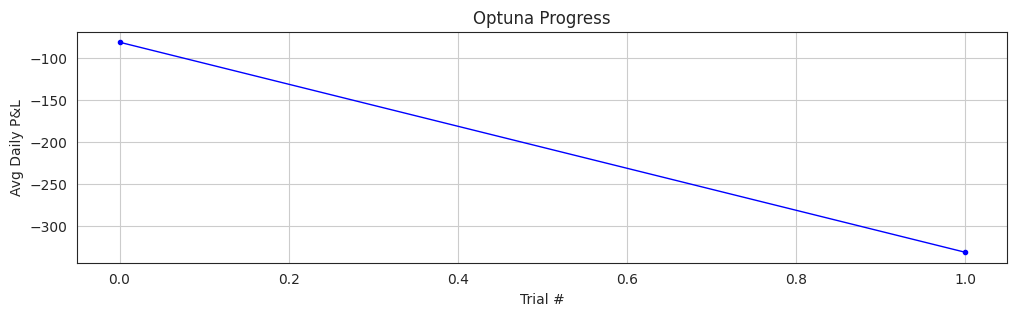

----------------------------------------------------------------------------------------------------------------------------------------------------------------
TRIAL 0 Params => reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=59; adx_thresh=9.080975006975123; atr_mult=29.254086583699635; vwap_atr_mult=7.075203630203746; buy_factor=0.3678253913631387; sell_factor=0.09666949335073327; trailstop_pct=22.159301732305764; thresh_mode=roll_p90; thresh_window=5


Gen&Sim: 100%|██████████| 1502/1502 [01:38<00:00, 15.28it/s]


[Results] mean_pnl:280.3575 mean_bh:361.2777 mean_excess:-80.9202 improv_vs_bh:-22.40%
Action counts: {'Buy': 23667, 'Sell': 2166, 'Hold': 1365107}
Best trial is: 0 with best_val: -80.9202
[save_results] wrote optuna_results/AAPL_-80.9202_pred_ML.csv
[save_best_json] wrote optuna_results/AAPL_-80.9202_pred_ML.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
TRIAL 1 Params => reset_peak=True; rsi_min_thresh=23; rsi_max_thresh=71; adx_thresh=12.078768344350468; atr_mult=24.260053363822855; vwap_atr_mult=2.9957607886366002; buy_factor=0.4436578404779543; sell_factor=0.028719918108301858; trailstop_pct=30.98498343296295; thresh_mode=numeric; thresh_mode_num=0.9505198716060177


Gen&Sim: 100%|██████████| 1502/1502 [02:20<00:00, 10.72it/s]


[Results] mean_pnl:29.9486 mean_bh:361.2777 mean_excess:-331.3291 improv_vs_bh:-91.71%
Action counts: {'Buy': 180, 'Sell': 106, 'Hold': 1390654}
Best trial is: 0 with best_val: -80.9202
----------------------------------------------------------------------------------------------------------------------------------------------------------------
TRIAL 2 Params => reset_peak=False; rsi_min_thresh=24; rsi_max_thresh=55; adx_thresh=15.14871747489682; atr_mult=24.561211932673043; vwap_atr_mult=7.420438557188496; buy_factor=0.5182917123295152; sell_factor=0.09980913564375347; trailstop_pct=32.90902748033404; thresh_mode=roll_p90; thresh_window=26


Thresh per day:  33%|███▎      | 501/1502 [01:30<03:00,  5.54it/s]


KeyboardInterrupt: 

In [6]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_trainval.loc[df_trainval.index.normalize() == df_trainval.index.normalize().min(), "ask"].iat[0]
end   = df_trainval.loc[df_trainval.index.normalize() == df_trainval.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_trainval.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 7000
trials_before_pruning = 250
trials_of_exploration = 350

n_days = df_trainval.index.normalize().nunique()
reports_per_trial = math.ceil(n_days / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("pred_ML")
cb_save_json = opts.make_save_best_json_callback("pred_ML")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()

In [ ]:
# # Single test: show actual columns produced by study.trials_dataframe()
# df_trials = study.trials_dataframe()
# print("columns:", df_trials.columns.tolist())
# display(df_trials.head(10))
